# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

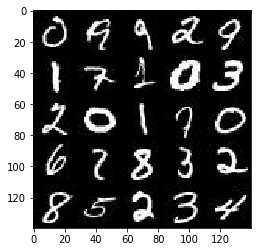

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

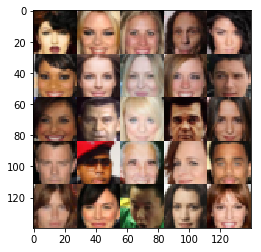

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels),name = "input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name = "input_z")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")

    return input_real, input_z, learning_rate 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
        # TODO: Implement Function
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse = reuse):
        # input size 28*28*3
        layer1 = tf.layers.conv2d(images, 64, 5, strides = 2,padding = 'same')
        relu1 = tf.maximum(0.12*layer1,layer1) # leaky relu

        # 14*14*64
        layer2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        layer2 = tf.nn.dropout(layer2, keep_prob=keep_prob)
        layer2 = tf.layers.batch_normalization(layer2, training = True)
        relu2 = tf.maximum(0.12*layer2,layer2)# leaky relu

        # 7*7*128
        layer3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        layer3 = tf.nn.dropout(layer3, keep_prob=keep_prob)
        layer3 = tf.layers.batch_normalization(layer3, training= True)
        relu3 = tf.maximum(0.12*layer3,layer3)

        flatten_layer = tf.reshape(relu3, (-1,4*4*256))
        flatten_layer = tf.layers.dropout(flatten_layer, rate=0.3)
        logits = tf.layers.dense(flatten_layer,1)
        
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        layer1 = tf.layers.dense(z,7*7*512);
        layer1 = tf.reshape(layer1,(-1,7,7,512))
        relu1 = tf.maximum(0.12*layer1,layer1)
        relu1 = tf.nn.dropout(relu1,keep_prob=0.8)
        
        # input 7*7*512
        layer2 = tf.layers.conv2d_transpose(relu1,256,5,strides=1,padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training = is_train)
        relu2 = tf.maximum(0.12*layer2,layer2)
        # output 7*7*256
        relu2 = tf.nn.dropout(relu2,keep_prob=0.8)
        
        layer3 = tf.layers.conv2d_transpose(relu2,128,5,strides=2,padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training = is_train)
        relu3  = tf.maximum(0.12*layer3,layer3)
        # 14*14*128
        
        logits = tf.layers.conv2d_transpose(relu3,out_channel_dim,5,strides=2,padding='same')
        output = tf.tanh(logits)
        
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                step+=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_optimizer, feed_dict = {input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_optimizer, feed_dict = {input_real:batch_images, input_z: batch_z, lr:learning_rate})
                
                if step%10==0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}".format(epoch_i),
                          "The No. {} steps loss_d is {}".format(step,train_loss_d),
                          "The No. {} steps loss_g is {}".format(step,train_loss_g))
                    
                if step%100==0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0 The No. 10 steps loss_d is 2.6616454124450684 The No. 10 steps loss_g is 0.20337776839733124
Epoch 0 The No. 20 steps loss_d is 0.7460012435913086 The No. 20 steps loss_g is 2.2463788986206055
Epoch 0 The No. 30 steps loss_d is 0.537684977054596 The No. 30 steps loss_g is 3.6459646224975586
Epoch 0 The No. 40 steps loss_d is 1.8677499294281006 The No. 40 steps loss_g is 0.5382991433143616
Epoch 0 The No. 50 steps loss_d is 0.5386407375335693 The No. 50 steps loss_g is 2.733865737915039
Epoch 0 The No. 60 steps loss_d is 4.392282962799072 The No. 60 steps loss_g is 7.961668968200684
Epoch 0 The No. 70 steps loss_d is 0.7611972093582153 The No. 70 steps loss_g is 2.0949268341064453
Epoch 0 The No. 80 steps loss_d is 0.7816506624221802 The No. 80 steps loss_g is 2.933835029602051
Epoch 0 The No. 90 steps loss_d is 0.5977121591567993 The No. 90 steps loss_g is 2.448430061340332
Epoch 0 The No. 100 steps loss_d is 0.7798169851303101 The No. 100 steps loss_g is 1.3314288854599


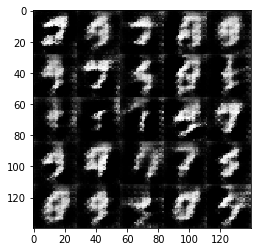

Epoch 0 The No. 110 steps loss_d is 0.45403939485549927 The No. 110 steps loss_g is 2.7108559608459473
Epoch 0 The No. 120 steps loss_d is 0.6161169409751892 The No. 120 steps loss_g is 2.3179996013641357
Epoch 0 The No. 130 steps loss_d is 0.48372983932495117 The No. 130 steps loss_g is 2.71591854095459
Epoch 0 The No. 140 steps loss_d is 0.3888748288154602 The No. 140 steps loss_g is 3.924687147140503
Epoch 0 The No. 150 steps loss_d is 0.510636568069458 The No. 150 steps loss_g is 5.952457904815674
Epoch 0 The No. 160 steps loss_d is 0.39364731311798096 The No. 160 steps loss_g is 3.779817581176758
Epoch 0 The No. 170 steps loss_d is 1.3025695085525513 The No. 170 steps loss_g is 1.5416723489761353
Epoch 0 The No. 180 steps loss_d is 0.6801828742027283 The No. 180 steps loss_g is 3.5709922313690186
Epoch 0 The No. 190 steps loss_d is 0.9669644832611084 The No. 190 steps loss_g is 4.790372848510742
Epoch 0 The No. 200 steps loss_d is 0.4960503876209259 The No. 200 steps loss_g is 2.3

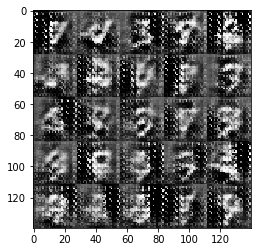

Epoch 0 The No. 210 steps loss_d is 0.423572838306427 The No. 210 steps loss_g is 4.6104736328125
Epoch 0 The No. 220 steps loss_d is 0.530119001865387 The No. 220 steps loss_g is 4.110295295715332
Epoch 0 The No. 230 steps loss_d is 0.5784612894058228 The No. 230 steps loss_g is 4.08650016784668
Epoch 0 The No. 240 steps loss_d is 1.689190149307251 The No. 240 steps loss_g is 2.772559642791748
Epoch 0 The No. 250 steps loss_d is 1.3062916994094849 The No. 250 steps loss_g is 0.65415358543396
Epoch 0 The No. 260 steps loss_d is 0.5794715881347656 The No. 260 steps loss_g is 2.172478675842285
Epoch 0 The No. 270 steps loss_d is 1.8616336584091187 The No. 270 steps loss_g is 0.31763124465942383
Epoch 0 The No. 280 steps loss_d is 0.8605262041091919 The No. 280 steps loss_g is 1.1240553855895996
Epoch 0 The No. 290 steps loss_d is 0.5357155799865723 The No. 290 steps loss_g is 3.05839467048645
Epoch 0 The No. 300 steps loss_d is 0.5468870997428894 The No. 300 steps loss_g is 2.71131563186

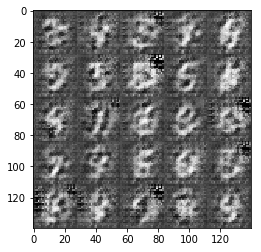

Epoch 0 The No. 310 steps loss_d is 1.2154712677001953 The No. 310 steps loss_g is 0.837769627571106
Epoch 0 The No. 320 steps loss_d is 0.8614717125892639 The No. 320 steps loss_g is 1.2647407054901123
Epoch 0 The No. 330 steps loss_d is 1.4478917121887207 The No. 330 steps loss_g is 0.7413416504859924
Epoch 0 The No. 340 steps loss_d is 0.8372116684913635 The No. 340 steps loss_g is 3.4807939529418945
Epoch 0 The No. 350 steps loss_d is 0.5587976574897766 The No. 350 steps loss_g is 2.453976631164551
Epoch 0 The No. 360 steps loss_d is 0.4655815362930298 The No. 360 steps loss_g is 3.363403797149658
Epoch 0 The No. 370 steps loss_d is 0.48334044218063354 The No. 370 steps loss_g is 2.9041848182678223
Epoch 0 The No. 380 steps loss_d is 1.5065783262252808 The No. 380 steps loss_g is 0.47536134719848633
Epoch 0 The No. 390 steps loss_d is 0.9253901243209839 The No. 390 steps loss_g is 3.3030714988708496
Epoch 0 The No. 400 steps loss_d is 0.8297474980354309 The No. 400 steps loss_g is 

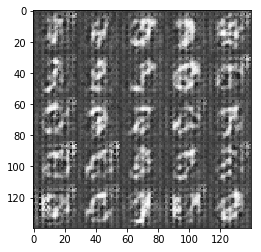

Epoch 0 The No. 410 steps loss_d is 1.0127334594726562 The No. 410 steps loss_g is 1.2081207036972046
Epoch 0 The No. 420 steps loss_d is 0.5215435028076172 The No. 420 steps loss_g is 2.2134673595428467
Epoch 0 The No. 430 steps loss_d is 0.7534030675888062 The No. 430 steps loss_g is 1.718680500984192
Epoch 0 The No. 440 steps loss_d is 0.6198288798332214 The No. 440 steps loss_g is 2.2525134086608887
Epoch 0 The No. 450 steps loss_d is 0.38550806045532227 The No. 450 steps loss_g is 3.7989139556884766
Epoch 0 The No. 460 steps loss_d is 0.887232780456543 The No. 460 steps loss_g is 1.1978774070739746
Epoch 1 The No. 10 steps loss_d is 0.6254292726516724 The No. 10 steps loss_g is 1.6510117053985596
Epoch 1 The No. 20 steps loss_d is 0.4932784140110016 The No. 20 steps loss_g is 2.156625270843506
Epoch 1 The No. 30 steps loss_d is 0.35490062832832336 The No. 30 steps loss_g is 5.075484752655029
Epoch 1 The No. 40 steps loss_d is 0.5330140590667725 The No. 40 steps loss_g is 1.9877117

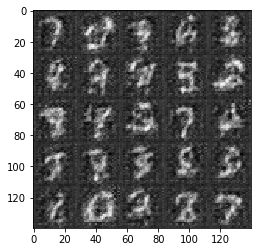

Epoch 1 The No. 110 steps loss_d is 0.6840898990631104 The No. 110 steps loss_g is 1.6545898914337158
Epoch 1 The No. 120 steps loss_d is 0.6384478211402893 The No. 120 steps loss_g is 1.6819010972976685
Epoch 1 The No. 130 steps loss_d is 0.7376449108123779 The No. 130 steps loss_g is 3.575777769088745
Epoch 1 The No. 140 steps loss_d is 0.7181686162948608 The No. 140 steps loss_g is 1.630428671836853
Epoch 1 The No. 150 steps loss_d is 0.7773680686950684 The No. 150 steps loss_g is 1.5658605098724365
Epoch 1 The No. 160 steps loss_d is 0.633837103843689 The No. 160 steps loss_g is 1.8778589963912964
Epoch 1 The No. 170 steps loss_d is 0.42041438817977905 The No. 170 steps loss_g is 3.5730652809143066
Epoch 1 The No. 180 steps loss_d is 0.5716139674186707 The No. 180 steps loss_g is 5.598835468292236
Epoch 1 The No. 190 steps loss_d is 1.041347622871399 The No. 190 steps loss_g is 0.9293458461761475
Epoch 1 The No. 200 steps loss_d is 0.6083006858825684 The No. 200 steps loss_g is 2.1

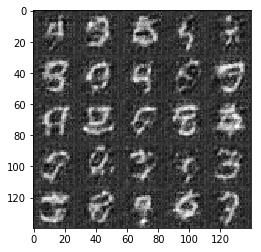

Epoch 1 The No. 210 steps loss_d is 0.5630892515182495 The No. 210 steps loss_g is 2.079134464263916
Epoch 1 The No. 220 steps loss_d is 0.8344871401786804 The No. 220 steps loss_g is 1.3715834617614746
Epoch 1 The No. 230 steps loss_d is 0.4285277724266052 The No. 230 steps loss_g is 3.4228169918060303
Epoch 1 The No. 240 steps loss_d is 0.458942174911499 The No. 240 steps loss_g is 2.5033419132232666
Epoch 1 The No. 250 steps loss_d is 0.4068266749382019 The No. 250 steps loss_g is 3.337484359741211
Epoch 1 The No. 260 steps loss_d is 0.3965749144554138 The No. 260 steps loss_g is 3.824195384979248
Epoch 1 The No. 270 steps loss_d is 0.36589354276657104 The No. 270 steps loss_g is 4.75040864944458
Epoch 1 The No. 280 steps loss_d is 0.3800092339515686 The No. 280 steps loss_g is 4.084880828857422
Epoch 1 The No. 290 steps loss_d is 0.4222896695137024 The No. 290 steps loss_g is 3.419552803039551
Epoch 1 The No. 300 steps loss_d is 0.4018927812576294 The No. 300 steps loss_g is 3.4820

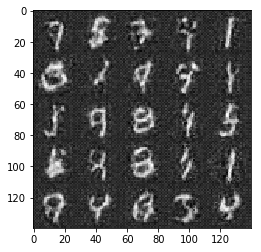

Epoch 1 The No. 310 steps loss_d is 0.5140096545219421 The No. 310 steps loss_g is 2.2116785049438477
Epoch 1 The No. 320 steps loss_d is 0.9935146570205688 The No. 320 steps loss_g is 0.9990522861480713
Epoch 1 The No. 330 steps loss_d is 0.6734380125999451 The No. 330 steps loss_g is 1.8279097080230713
Epoch 1 The No. 340 steps loss_d is 0.9766002893447876 The No. 340 steps loss_g is 0.9321527481079102
Epoch 1 The No. 350 steps loss_d is 0.4584026336669922 The No. 350 steps loss_g is 3.1089630126953125
Epoch 1 The No. 360 steps loss_d is 0.5232713222503662 The No. 360 steps loss_g is 2.2110962867736816
Epoch 1 The No. 370 steps loss_d is 1.0454859733581543 The No. 370 steps loss_g is 1.8091728687286377
Epoch 1 The No. 380 steps loss_d is 1.6003817319869995 The No. 380 steps loss_g is 2.7907118797302246
Epoch 1 The No. 390 steps loss_d is 0.9903391003608704 The No. 390 steps loss_g is 1.38239586353302
Epoch 1 The No. 400 steps loss_d is 0.9494872093200684 The No. 400 steps loss_g is 2

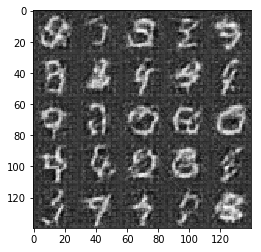

Epoch 1 The No. 410 steps loss_d is 0.7555342316627502 The No. 410 steps loss_g is 1.7134438753128052
Epoch 1 The No. 420 steps loss_d is 1.0822806358337402 The No. 420 steps loss_g is 0.8292528390884399
Epoch 1 The No. 430 steps loss_d is 0.606036365032196 The No. 430 steps loss_g is 2.8402349948883057
Epoch 1 The No. 440 steps loss_d is 0.5557527542114258 The No. 440 steps loss_g is 2.9541356563568115
Epoch 1 The No. 450 steps loss_d is 0.5856003761291504 The No. 450 steps loss_g is 2.0322823524475098
Epoch 1 The No. 460 steps loss_d is 3.228443145751953 The No. 460 steps loss_g is 5.579948425292969


In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0 The No. 10 steps loss_d is 0.8152341246604919 The No. 10 steps loss_g is 1.5531306266784668
Epoch 0 The No. 20 steps loss_d is 0.5636841058731079 The No. 20 steps loss_g is 2.2701878547668457
Epoch 0 The No. 30 steps loss_d is 0.5511633157730103 The No. 30 steps loss_g is 2.2221200466156006
Epoch 0 The No. 40 steps loss_d is 0.5284302830696106 The No. 40 steps loss_g is 2.585676431655884
Epoch 0 The No. 50 steps loss_d is 0.5005831718444824 The No. 50 steps loss_g is 2.8778464794158936
Epoch 0 The No. 60 steps loss_d is 0.5628999471664429 The No. 60 steps loss_g is 2.869290351867676
Epoch 0 The No. 70 steps loss_d is 0.5511829853057861 The No. 70 steps loss_g is 2.882279396057129
Epoch 0 The No. 80 steps loss_d is 0.5298275351524353 The No. 80 steps loss_g is 3.066593885421753
Epoch 0 The No. 90 steps loss_d is 0.6840977668762207 The No. 90 steps loss_g is 2.3162155151367188
Epoch 0 The No. 100 steps loss_d is 0.5192716121673584 The No. 100 steps loss_g is 3.7795705795288086


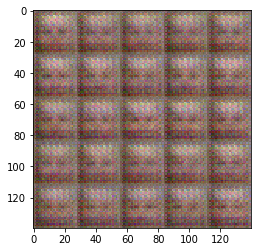

Epoch 0 The No. 110 steps loss_d is 0.5817604660987854 The No. 110 steps loss_g is 2.536184310913086
Epoch 0 The No. 120 steps loss_d is 0.5126391053199768 The No. 120 steps loss_g is 2.5830421447753906
Epoch 0 The No. 130 steps loss_d is 0.4320984482765198 The No. 130 steps loss_g is 3.646765947341919
Epoch 0 The No. 140 steps loss_d is 0.4734010100364685 The No. 140 steps loss_g is 2.986490249633789
Epoch 0 The No. 150 steps loss_d is 0.47843271493911743 The No. 150 steps loss_g is 3.6278553009033203
Epoch 0 The No. 160 steps loss_d is 0.4407923221588135 The No. 160 steps loss_g is 3.1498568058013916
Epoch 0 The No. 170 steps loss_d is 0.44805198907852173 The No. 170 steps loss_g is 3.6238417625427246
Epoch 0 The No. 180 steps loss_d is 0.4552469253540039 The No. 180 steps loss_g is 2.993541717529297
Epoch 0 The No. 190 steps loss_d is 0.4694063663482666 The No. 190 steps loss_g is 3.038325548171997
Epoch 0 The No. 200 steps loss_d is 0.434938907623291 The No. 200 steps loss_g is 3.3

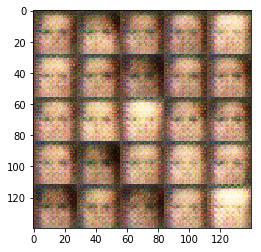

Epoch 0 The No. 210 steps loss_d is 0.4615243077278137 The No. 210 steps loss_g is 3.564105987548828
Epoch 0 The No. 220 steps loss_d is 0.5117444396018982 The No. 220 steps loss_g is 2.7837297916412354
Epoch 0 The No. 230 steps loss_d is 0.38521894812583923 The No. 230 steps loss_g is 4.405367374420166
Epoch 0 The No. 240 steps loss_d is 0.43268829584121704 The No. 240 steps loss_g is 3.26718807220459
Epoch 0 The No. 250 steps loss_d is 0.40867120027542114 The No. 250 steps loss_g is 3.5038256645202637
Epoch 0 The No. 260 steps loss_d is 0.40107887983322144 The No. 260 steps loss_g is 3.7239768505096436
Epoch 0 The No. 270 steps loss_d is 0.3889845907688141 The No. 270 steps loss_g is 3.6209967136383057
Epoch 0 The No. 280 steps loss_d is 0.3898743987083435 The No. 280 steps loss_g is 4.510395050048828
Epoch 0 The No. 290 steps loss_d is 0.4097990393638611 The No. 290 steps loss_g is 3.4334702491760254
Epoch 0 The No. 300 steps loss_d is 0.40093982219696045 The No. 300 steps loss_g is

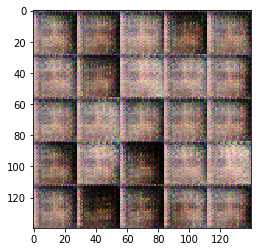

Epoch 0 The No. 310 steps loss_d is 0.42526280879974365 The No. 310 steps loss_g is 3.792548179626465
Epoch 0 The No. 320 steps loss_d is 0.45537787675857544 The No. 320 steps loss_g is 2.8024027347564697
Epoch 0 The No. 330 steps loss_d is 0.5469878315925598 The No. 330 steps loss_g is 2.3331398963928223
Epoch 0 The No. 340 steps loss_d is 0.5571491122245789 The No. 340 steps loss_g is 3.147653579711914
Epoch 0 The No. 350 steps loss_d is 0.6091672778129578 The No. 350 steps loss_g is 2.3447508811950684
Epoch 0 The No. 360 steps loss_d is 0.5749761462211609 The No. 360 steps loss_g is 3.6869921684265137
Epoch 0 The No. 370 steps loss_d is 0.5205867886543274 The No. 370 steps loss_g is 3.653465986251831
Epoch 0 The No. 380 steps loss_d is 0.8925192356109619 The No. 380 steps loss_g is 1.5090208053588867
Epoch 0 The No. 390 steps loss_d is 0.7340838313102722 The No. 390 steps loss_g is 2.0644984245300293
Epoch 0 The No. 400 steps loss_d is 0.6026793718338013 The No. 400 steps loss_g is 

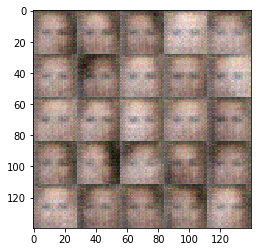

Epoch 0 The No. 410 steps loss_d is 0.5075385570526123 The No. 410 steps loss_g is 2.7361927032470703
Epoch 0 The No. 420 steps loss_d is 0.6424329876899719 The No. 420 steps loss_g is 3.598997116088867
Epoch 0 The No. 430 steps loss_d is 0.5572980642318726 The No. 430 steps loss_g is 2.2466559410095215
Epoch 0 The No. 440 steps loss_d is 0.6779563426971436 The No. 440 steps loss_g is 1.9240355491638184
Epoch 0 The No. 450 steps loss_d is 0.581666886806488 The No. 450 steps loss_g is 2.560983180999756
Epoch 0 The No. 460 steps loss_d is 0.5346403121948242 The No. 460 steps loss_g is 3.353095054626465
Epoch 0 The No. 470 steps loss_d is 0.5440181493759155 The No. 470 steps loss_g is 2.9985780715942383
Epoch 0 The No. 480 steps loss_d is 0.5646024346351624 The No. 480 steps loss_g is 2.3115615844726562
Epoch 0 The No. 490 steps loss_d is 0.6601674556732178 The No. 490 steps loss_g is 2.002729654312134
Epoch 0 The No. 500 steps loss_d is 0.5684917569160461 The No. 500 steps loss_g is 3.37

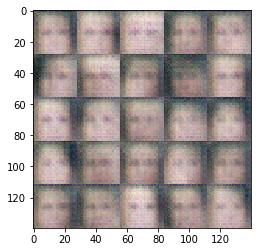

Epoch 0 The No. 510 steps loss_d is 0.5554341077804565 The No. 510 steps loss_g is 2.3416948318481445
Epoch 0 The No. 520 steps loss_d is 0.600609540939331 The No. 520 steps loss_g is 2.3204686641693115
Epoch 0 The No. 530 steps loss_d is 0.6267741322517395 The No. 530 steps loss_g is 1.9135407209396362
Epoch 0 The No. 540 steps loss_d is 0.7248226404190063 The No. 540 steps loss_g is 1.5009979009628296
Epoch 0 The No. 550 steps loss_d is 0.8869585990905762 The No. 550 steps loss_g is 1.3341988325119019
Epoch 0 The No. 560 steps loss_d is 0.5724656581878662 The No. 560 steps loss_g is 2.6462554931640625
Epoch 0 The No. 570 steps loss_d is 0.5039782524108887 The No. 570 steps loss_g is 3.0124874114990234
Epoch 0 The No. 580 steps loss_d is 0.5502967834472656 The No. 580 steps loss_g is 2.3388986587524414
Epoch 0 The No. 590 steps loss_d is 0.6082932353019714 The No. 590 steps loss_g is 2.4067351818084717
Epoch 0 The No. 600 steps loss_d is 0.5947993397712708 The No. 600 steps loss_g is 

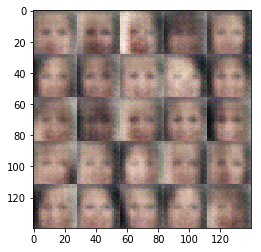

Epoch 0 The No. 610 steps loss_d is 0.5159710645675659 The No. 610 steps loss_g is 2.8601434230804443
Epoch 0 The No. 620 steps loss_d is 0.6828101277351379 The No. 620 steps loss_g is 2.7283453941345215
Epoch 0 The No. 630 steps loss_d is 0.7423076033592224 The No. 630 steps loss_g is 2.8019051551818848
Epoch 0 The No. 640 steps loss_d is 0.6016712188720703 The No. 640 steps loss_g is 2.5728468894958496
Epoch 0 The No. 650 steps loss_d is 0.5814942121505737 The No. 650 steps loss_g is 2.2322967052459717
Epoch 0 The No. 660 steps loss_d is 0.6246261596679688 The No. 660 steps loss_g is 2.7204415798187256
Epoch 0 The No. 670 steps loss_d is 0.7599664926528931 The No. 670 steps loss_g is 2.8215951919555664
Epoch 0 The No. 680 steps loss_d is 0.5600763559341431 The No. 680 steps loss_g is 2.282904624938965
Epoch 0 The No. 690 steps loss_d is 0.510402500629425 The No. 690 steps loss_g is 3.1407628059387207
Epoch 0 The No. 700 steps loss_d is 0.5933282971382141 The No. 700 steps loss_g is 2

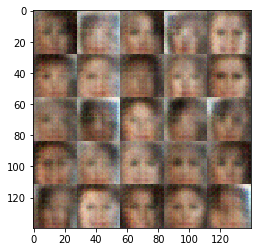

Epoch 0 The No. 710 steps loss_d is 0.6343825459480286 The No. 710 steps loss_g is 4.21141242980957
Epoch 0 The No. 720 steps loss_d is 0.5818415880203247 The No. 720 steps loss_g is 2.4723663330078125
Epoch 0 The No. 730 steps loss_d is 0.5764907002449036 The No. 730 steps loss_g is 2.0817041397094727
Epoch 0 The No. 740 steps loss_d is 0.6837689280509949 The No. 740 steps loss_g is 1.6940988302230835
Epoch 0 The No. 750 steps loss_d is 0.49415966868400574 The No. 750 steps loss_g is 2.9886534214019775
Epoch 0 The No. 760 steps loss_d is 0.5169943571090698 The No. 760 steps loss_g is 2.6184701919555664
Epoch 0 The No. 770 steps loss_d is 0.5203146934509277 The No. 770 steps loss_g is 2.9506304264068604
Epoch 0 The No. 780 steps loss_d is 0.47473958134651184 The No. 780 steps loss_g is 4.092072486877441
Epoch 0 The No. 790 steps loss_d is 0.5338845252990723 The No. 790 steps loss_g is 4.712052345275879
Epoch 0 The No. 800 steps loss_d is 0.45639196038246155 The No. 800 steps loss_g is 

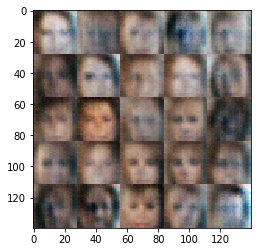

Epoch 0 The No. 810 steps loss_d is 0.5463777780532837 The No. 810 steps loss_g is 3.141017436981201
Epoch 0 The No. 820 steps loss_d is 0.5831402540206909 The No. 820 steps loss_g is 2.0508925914764404
Epoch 0 The No. 830 steps loss_d is 0.5414657592773438 The No. 830 steps loss_g is 2.3157339096069336
Epoch 0 The No. 840 steps loss_d is 0.49558010697364807 The No. 840 steps loss_g is 3.5529370307922363
Epoch 0 The No. 850 steps loss_d is 0.49789634346961975 The No. 850 steps loss_g is 3.884885311126709
Epoch 0 The No. 860 steps loss_d is 1.1168829202651978 The No. 860 steps loss_g is 5.679880619049072
Epoch 0 The No. 870 steps loss_d is 0.5018494129180908 The No. 870 steps loss_g is 3.0263442993164062
Epoch 0 The No. 880 steps loss_d is 0.46584588289260864 The No. 880 steps loss_g is 4.688068389892578
Epoch 0 The No. 890 steps loss_d is 0.5367062091827393 The No. 890 steps loss_g is 5.072948455810547
Epoch 0 The No. 900 steps loss_d is 0.47733256220817566 The No. 900 steps loss_g is 

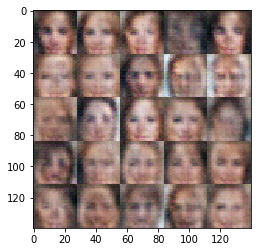

Epoch 0 The No. 910 steps loss_d is 0.6538296937942505 The No. 910 steps loss_g is 1.8327839374542236
Epoch 0 The No. 920 steps loss_d is 0.5190014839172363 The No. 920 steps loss_g is 4.401248931884766
Epoch 0 The No. 930 steps loss_d is 0.4655080735683441 The No. 930 steps loss_g is 2.7974746227264404
Epoch 0 The No. 940 steps loss_d is 0.4459300637245178 The No. 940 steps loss_g is 4.187431812286377
Epoch 0 The No. 950 steps loss_d is 0.8308309316635132 The No. 950 steps loss_g is 1.4875011444091797
Epoch 0 The No. 960 steps loss_d is 0.5552679300308228 The No. 960 steps loss_g is 2.3006248474121094
Epoch 0 The No. 970 steps loss_d is 0.4654972553253174 The No. 970 steps loss_g is 4.736122131347656
Epoch 0 The No. 980 steps loss_d is 0.5247322916984558 The No. 980 steps loss_g is 3.008796215057373
Epoch 0 The No. 990 steps loss_d is 0.547062873840332 The No. 990 steps loss_g is 2.217914342880249
Epoch 0 The No. 1000 steps loss_d is 0.4387476146221161 The No. 1000 steps loss_g is 3.3

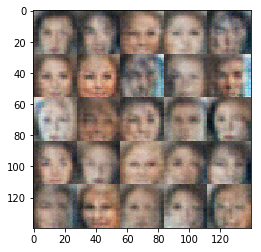

Epoch 0 The No. 1010 steps loss_d is 1.946706771850586 The No. 1010 steps loss_g is 0.5108844041824341
Epoch 0 The No. 1020 steps loss_d is 0.5201189517974854 The No. 1020 steps loss_g is 2.318899393081665
Epoch 0 The No. 1030 steps loss_d is 0.887362003326416 The No. 1030 steps loss_g is 1.2426236867904663
Epoch 0 The No. 1040 steps loss_d is 0.6624680161476135 The No. 1040 steps loss_g is 6.332972049713135
Epoch 0 The No. 1050 steps loss_d is 0.4725468158721924 The No. 1050 steps loss_g is 3.0619864463806152
Epoch 0 The No. 1060 steps loss_d is 1.0724966526031494 The No. 1060 steps loss_g is 0.9765259623527527
Epoch 0 The No. 1070 steps loss_d is 0.9720147848129272 The No. 1070 steps loss_g is 1.0531949996948242
Epoch 0 The No. 1080 steps loss_d is 0.8143608570098877 The No. 1080 steps loss_g is 1.2543331384658813
Epoch 0 The No. 1090 steps loss_d is 0.3930739760398865 The No. 1090 steps loss_g is 4.218635559082031
Epoch 0 The No. 1100 steps loss_d is 0.7229192852973938 The No. 1100 

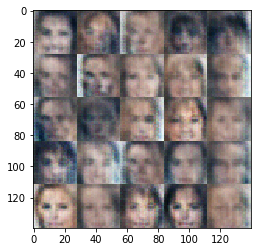

Epoch 0 The No. 1110 steps loss_d is 0.5080016255378723 The No. 1110 steps loss_g is 2.237482786178589
Epoch 0 The No. 1120 steps loss_d is 0.5311129093170166 The No. 1120 steps loss_g is 4.4028143882751465
Epoch 0 The No. 1130 steps loss_d is 0.6078990697860718 The No. 1130 steps loss_g is 3.933234214782715
Epoch 0 The No. 1140 steps loss_d is 0.6123583316802979 The No. 1140 steps loss_g is 1.7476035356521606
Epoch 0 The No. 1150 steps loss_d is 1.085513710975647 The No. 1150 steps loss_g is 0.9335498809814453
Epoch 0 The No. 1160 steps loss_d is 0.7493913173675537 The No. 1160 steps loss_g is 1.4976880550384521
Epoch 0 The No. 1170 steps loss_d is 0.3747745454311371 The No. 1170 steps loss_g is 4.529767036437988
Epoch 0 The No. 1180 steps loss_d is 0.8330174088478088 The No. 1180 steps loss_g is 1.261941909790039
Epoch 0 The No. 1190 steps loss_d is 0.4183107018470764 The No. 1190 steps loss_g is 3.6377015113830566
Epoch 0 The No. 1200 steps loss_d is 0.48966482281684875 The No. 1200

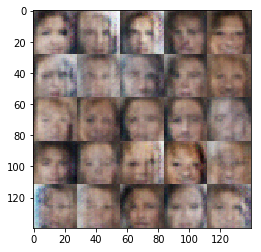

Epoch 0 The No. 1210 steps loss_d is 0.792429506778717 The No. 1210 steps loss_g is 1.1470983028411865
Epoch 0 The No. 1220 steps loss_d is 0.40400266647338867 The No. 1220 steps loss_g is 3.739027261734009
Epoch 0 The No. 1230 steps loss_d is 0.37459221482276917 The No. 1230 steps loss_g is 5.629746437072754
Epoch 0 The No. 1240 steps loss_d is 0.7138527631759644 The No. 1240 steps loss_g is 1.7315549850463867
Epoch 0 The No. 1250 steps loss_d is 0.5556840896606445 The No. 1250 steps loss_g is 2.765943765640259
Epoch 0 The No. 1260 steps loss_d is 0.40130850672721863 The No. 1260 steps loss_g is 4.5174360275268555
Epoch 0 The No. 1270 steps loss_d is 1.0557682514190674 The No. 1270 steps loss_g is 0.8687231540679932
Epoch 0 The No. 1280 steps loss_d is 0.43550145626068115 The No. 1280 steps loss_g is 3.8407907485961914
Epoch 0 The No. 1290 steps loss_d is 0.546765923500061 The No. 1290 steps loss_g is 2.5652413368225098
Epoch 0 The No. 1300 steps loss_d is 0.5001978278160095 The No. 1

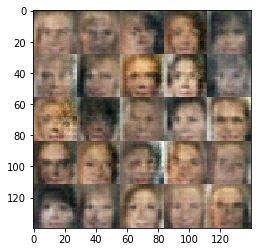

Epoch 0 The No. 1310 steps loss_d is 0.3542928099632263 The No. 1310 steps loss_g is 7.4116010665893555
Epoch 0 The No. 1320 steps loss_d is 0.43634143471717834 The No. 1320 steps loss_g is 2.9208571910858154
Epoch 0 The No. 1330 steps loss_d is 0.7834539413452148 The No. 1330 steps loss_g is 1.3932808637619019
Epoch 0 The No. 1340 steps loss_d is 0.6478374004364014 The No. 1340 steps loss_g is 4.369551658630371
Epoch 0 The No. 1350 steps loss_d is 0.46500545740127563 The No. 1350 steps loss_g is 7.837673664093018
Epoch 0 The No. 1360 steps loss_d is 0.6797249913215637 The No. 1360 steps loss_g is 7.049420356750488
Epoch 0 The No. 1370 steps loss_d is 0.36020544171333313 The No. 1370 steps loss_g is 4.893059730529785
Epoch 0 The No. 1380 steps loss_d is 0.5348047018051147 The No. 1380 steps loss_g is 5.187956809997559
Epoch 0 The No. 1390 steps loss_d is 0.43140652775764465 The No. 1390 steps loss_g is 3.5569140911102295
Epoch 0 The No. 1400 steps loss_d is 0.4690200090408325 The No. 1

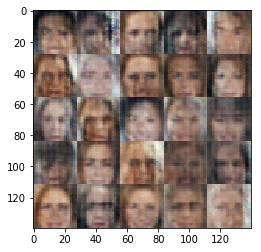

Epoch 0 The No. 1410 steps loss_d is 0.8175156116485596 The No. 1410 steps loss_g is 1.273474931716919
Epoch 0 The No. 1420 steps loss_d is 0.37449613213539124 The No. 1420 steps loss_g is 5.899124622344971
Epoch 0 The No. 1430 steps loss_d is 0.36323440074920654 The No. 1430 steps loss_g is 6.028653621673584
Epoch 0 The No. 1440 steps loss_d is 0.36354243755340576 The No. 1440 steps loss_g is 7.178805351257324
Epoch 0 The No. 1450 steps loss_d is 0.3617410659790039 The No. 1450 steps loss_g is 5.940600872039795
Epoch 0 The No. 1460 steps loss_d is 0.3916260600090027 The No. 1460 steps loss_g is 6.647082328796387
Epoch 0 The No. 1470 steps loss_d is 0.423555850982666 The No. 1470 steps loss_g is 3.6112914085388184
Epoch 0 The No. 1480 steps loss_d is 0.38363832235336304 The No. 1480 steps loss_g is 3.943364143371582
Epoch 0 The No. 1490 steps loss_d is 0.36605435609817505 The No. 1490 steps loss_g is 5.962703227996826
Epoch 0 The No. 1500 steps loss_d is 0.36138737201690674 The No. 150

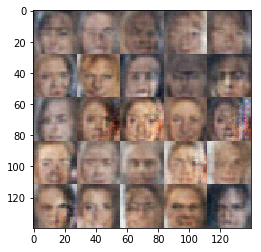

Epoch 0 The No. 1510 steps loss_d is 0.38867586851119995 The No. 1510 steps loss_g is 5.154608726501465
Epoch 0 The No. 1520 steps loss_d is 0.37352490425109863 The No. 1520 steps loss_g is 6.848801612854004
Epoch 0 The No. 1530 steps loss_d is 0.378542959690094 The No. 1530 steps loss_g is 6.831185340881348
Epoch 0 The No. 1540 steps loss_d is 0.5810768604278564 The No. 1540 steps loss_g is 2.508697986602783
Epoch 0 The No. 1550 steps loss_d is 0.36493128538131714 The No. 1550 steps loss_g is 7.2277421951293945
Epoch 0 The No. 1560 steps loss_d is 0.36655715107917786 The No. 1560 steps loss_g is 8.271167755126953
Epoch 0 The No. 1570 steps loss_d is 0.5011877417564392 The No. 1570 steps loss_g is 2.088831901550293
Epoch 0 The No. 1580 steps loss_d is 0.37664923071861267 The No. 1580 steps loss_g is 5.884177207946777
Epoch 0 The No. 1590 steps loss_d is 0.3801375925540924 The No. 1590 steps loss_g is 6.431919574737549
Epoch 0 The No. 1600 steps loss_d is 0.5592683553695679 The No. 1600

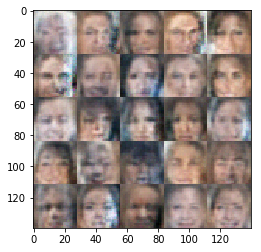

Epoch 0 The No. 1610 steps loss_d is 0.47285163402557373 The No. 1610 steps loss_g is 3.7093706130981445
Epoch 0 The No. 1620 steps loss_d is 0.8321450352668762 The No. 1620 steps loss_g is 1.2677457332611084
Epoch 0 The No. 1630 steps loss_d is 0.38082075119018555 The No. 1630 steps loss_g is 4.035396575927734
Epoch 0 The No. 1640 steps loss_d is 1.5447661876678467 The No. 1640 steps loss_g is 10.720191955566406
Epoch 0 The No. 1650 steps loss_d is 0.5484176278114319 The No. 1650 steps loss_g is 2.0471363067626953
Epoch 0 The No. 1660 steps loss_d is 0.4773719310760498 The No. 1660 steps loss_g is 2.4405555725097656
Epoch 0 The No. 1670 steps loss_d is 0.41818320751190186 The No. 1670 steps loss_g is 3.711569309234619
Epoch 0 The No. 1680 steps loss_d is 0.36671894788742065 The No. 1680 steps loss_g is 6.092838287353516
Epoch 0 The No. 1690 steps loss_d is 0.3531498908996582 The No. 1690 steps loss_g is 8.409470558166504
Epoch 0 The No. 1700 steps loss_d is 0.35956013202667236 The No.

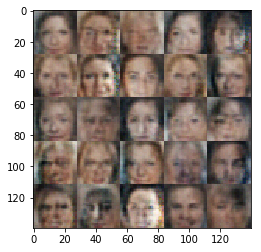

Epoch 0 The No. 1710 steps loss_d is 0.3490956127643585 The No. 1710 steps loss_g is 5.960671424865723
Epoch 0 The No. 1720 steps loss_d is 0.348341703414917 The No. 1720 steps loss_g is 7.109297275543213
Epoch 0 The No. 1730 steps loss_d is 0.35864970088005066 The No. 1730 steps loss_g is 6.2469916343688965
Epoch 0 The No. 1740 steps loss_d is 0.3579835295677185 The No. 1740 steps loss_g is 6.694099426269531
Epoch 0 The No. 1750 steps loss_d is 0.37092024087905884 The No. 1750 steps loss_g is 6.507872581481934
Epoch 0 The No. 1760 steps loss_d is 0.4411813020706177 The No. 1760 steps loss_g is 2.4799461364746094
Epoch 0 The No. 1770 steps loss_d is 0.3726511299610138 The No. 1770 steps loss_g is 4.130950927734375
Epoch 0 The No. 1780 steps loss_d is 0.3520101010799408 The No. 1780 steps loss_g is 5.285024642944336
Epoch 0 The No. 1790 steps loss_d is 0.3583269715309143 The No. 1790 steps loss_g is 7.118206024169922
Epoch 0 The No. 1800 steps loss_d is 0.3665401339530945 The No. 1800 s

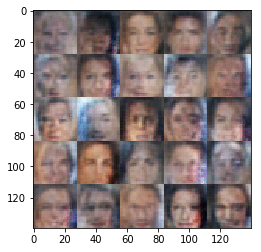

Epoch 0 The No. 1810 steps loss_d is 0.3775815963745117 The No. 1810 steps loss_g is 5.077783584594727
Epoch 0 The No. 1820 steps loss_d is 0.3544713854789734 The No. 1820 steps loss_g is 7.8331499099731445
Epoch 0 The No. 1830 steps loss_d is 0.3866710960865021 The No. 1830 steps loss_g is 4.421501159667969
Epoch 0 The No. 1840 steps loss_d is 0.3616883158683777 The No. 1840 steps loss_g is 4.931911468505859
Epoch 0 The No. 1850 steps loss_d is 0.34888756275177 The No. 1850 steps loss_g is 7.237648010253906
Epoch 0 The No. 1860 steps loss_d is 0.3620244562625885 The No. 1860 steps loss_g is 4.932031631469727
Epoch 0 The No. 1870 steps loss_d is 0.3763523995876312 The No. 1870 steps loss_g is 5.6587042808532715
Epoch 0 The No. 1880 steps loss_d is 0.9814531803131104 The No. 1880 steps loss_g is 6.527118682861328
Epoch 0 The No. 1890 steps loss_d is 0.3730143904685974 The No. 1890 steps loss_g is 4.204779624938965
Epoch 0 The No. 1900 steps loss_d is 0.3559529781341553 The No. 1900 step

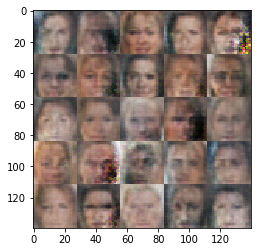

Epoch 0 The No. 1910 steps loss_d is 0.37035754323005676 The No. 1910 steps loss_g is 5.211972713470459
Epoch 0 The No. 1920 steps loss_d is 0.3513611853122711 The No. 1920 steps loss_g is 7.07830286026001
Epoch 0 The No. 1930 steps loss_d is 0.5297820568084717 The No. 1930 steps loss_g is 2.274012565612793
Epoch 0 The No. 1940 steps loss_d is 0.4184724986553192 The No. 1940 steps loss_g is 4.143688201904297
Epoch 0 The No. 1950 steps loss_d is 0.49318748712539673 The No. 1950 steps loss_g is 2.1472113132476807
Epoch 0 The No. 1960 steps loss_d is 0.4331483542919159 The No. 1960 steps loss_g is 4.91160249710083
Epoch 0 The No. 1970 steps loss_d is 0.37978509068489075 The No. 1970 steps loss_g is 3.879371404647827
Epoch 0 The No. 1980 steps loss_d is 0.3533990681171417 The No. 1980 steps loss_g is 8.284570693969727
Epoch 0 The No. 1990 steps loss_d is 0.40144920349121094 The No. 1990 steps loss_g is 6.816031455993652
Epoch 0 The No. 2000 steps loss_d is 0.3687995374202728 The No. 2000 s

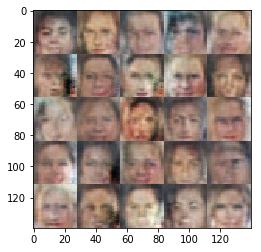

Epoch 0 The No. 2010 steps loss_d is 0.3501130938529968 The No. 2010 steps loss_g is 7.359626770019531
Epoch 0 The No. 2020 steps loss_d is 0.35272565484046936 The No. 2020 steps loss_g is 8.141263961791992
Epoch 0 The No. 2030 steps loss_d is 0.35372844338417053 The No. 2030 steps loss_g is 6.69003963470459
Epoch 0 The No. 2040 steps loss_d is 1.0471729040145874 The No. 2040 steps loss_g is 8.254838943481445
Epoch 0 The No. 2050 steps loss_d is 0.3757781386375427 The No. 2050 steps loss_g is 5.09348201751709
Epoch 0 The No. 2060 steps loss_d is 0.5598094463348389 The No. 2060 steps loss_g is 2.9073567390441895
Epoch 0 The No. 2070 steps loss_d is 0.5015279054641724 The No. 2070 steps loss_g is 2.212614059448242
Epoch 0 The No. 2080 steps loss_d is 0.3884708881378174 The No. 2080 steps loss_g is 3.7153444290161133
Epoch 0 The No. 2090 steps loss_d is 0.46093064546585083 The No. 2090 steps loss_g is 2.485428810119629
Epoch 0 The No. 2100 steps loss_d is 0.38160979747772217 The No. 2100 

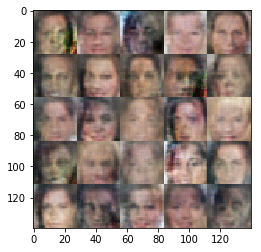

Epoch 0 The No. 2110 steps loss_d is 0.36360543966293335 The No. 2110 steps loss_g is 8.456921577453613
Epoch 0 The No. 2120 steps loss_d is 0.36807671189308167 The No. 2120 steps loss_g is 5.141385078430176
Epoch 0 The No. 2130 steps loss_d is 0.3613687753677368 The No. 2130 steps loss_g is 4.596240997314453
Epoch 0 The No. 2140 steps loss_d is 0.49873587489128113 The No. 2140 steps loss_g is 2.3443591594696045
Epoch 0 The No. 2150 steps loss_d is 0.3752060830593109 The No. 2150 steps loss_g is 4.782433032989502
Epoch 0 The No. 2160 steps loss_d is 0.35108545422554016 The No. 2160 steps loss_g is 7.307943820953369
Epoch 0 The No. 2170 steps loss_d is 0.6654676795005798 The No. 2170 steps loss_g is 1.8516900539398193
Epoch 0 The No. 2180 steps loss_d is 0.34343159198760986 The No. 2180 steps loss_g is 7.124991416931152
Epoch 0 The No. 2190 steps loss_d is 0.37561851739883423 The No. 2190 steps loss_g is 4.001791954040527
Epoch 0 The No. 2200 steps loss_d is 0.39630115032196045 The No. 

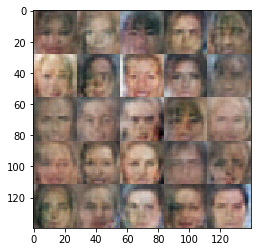

Epoch 0 The No. 2210 steps loss_d is 0.3594632148742676 The No. 2210 steps loss_g is 5.711507797241211
Epoch 0 The No. 2220 steps loss_d is 0.3562580943107605 The No. 2220 steps loss_g is 6.409542083740234
Epoch 0 The No. 2230 steps loss_d is 0.34877434372901917 The No. 2230 steps loss_g is 6.854008674621582
Epoch 0 The No. 2240 steps loss_d is 0.36551135778427124 The No. 2240 steps loss_g is 4.668621063232422
Epoch 0 The No. 2250 steps loss_d is 0.34692656993865967 The No. 2250 steps loss_g is 6.819207191467285
Epoch 0 The No. 2260 steps loss_d is 0.3513777256011963 The No. 2260 steps loss_g is 7.76251220703125
Epoch 0 The No. 2270 steps loss_d is 0.3452221751213074 The No. 2270 steps loss_g is 8.418949127197266
Epoch 0 The No. 2280 steps loss_d is 0.3539681136608124 The No. 2280 steps loss_g is 5.809412479400635
Epoch 0 The No. 2290 steps loss_d is 0.3557872772216797 The No. 2290 steps loss_g is 4.811465263366699
Epoch 0 The No. 2300 steps loss_d is 0.5751989483833313 The No. 2300 st

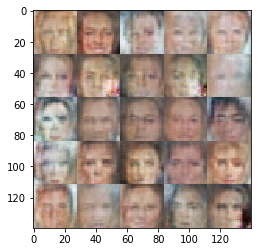

Epoch 0 The No. 2310 steps loss_d is 0.3671877980232239 The No. 2310 steps loss_g is 7.275716304779053
Epoch 0 The No. 2320 steps loss_d is 0.41119566559791565 The No. 2320 steps loss_g is 4.7493133544921875
Epoch 0 The No. 2330 steps loss_d is 0.4344954490661621 The No. 2330 steps loss_g is 3.1973989009857178
Epoch 0 The No. 2340 steps loss_d is 0.46414220333099365 The No. 2340 steps loss_g is 2.708786964416504
Epoch 0 The No. 2350 steps loss_d is 0.3490505516529083 The No. 2350 steps loss_g is 6.616566181182861
Epoch 0 The No. 2360 steps loss_d is 0.3456239700317383 The No. 2360 steps loss_g is 5.452338218688965
Epoch 0 The No. 2370 steps loss_d is 0.3549954295158386 The No. 2370 steps loss_g is 5.218886852264404
Epoch 0 The No. 2380 steps loss_d is 0.3493072986602783 The No. 2380 steps loss_g is 6.457265853881836
Epoch 0 The No. 2390 steps loss_d is 0.35770803689956665 The No. 2390 steps loss_g is 5.856907367706299
Epoch 0 The No. 2400 steps loss_d is 0.35697072744369507 The No. 240

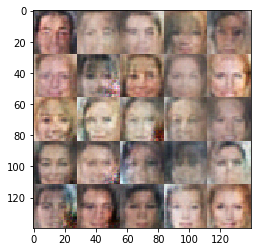

Epoch 0 The No. 2410 steps loss_d is 0.5737542510032654 The No. 2410 steps loss_g is 8.314582824707031
Epoch 0 The No. 2420 steps loss_d is 0.3612147569656372 The No. 2420 steps loss_g is 5.952001094818115
Epoch 0 The No. 2430 steps loss_d is 0.5769748091697693 The No. 2430 steps loss_g is 7.6922221183776855
Epoch 0 The No. 2440 steps loss_d is 0.3436657786369324 The No. 2440 steps loss_g is 7.198886871337891
Epoch 0 The No. 2450 steps loss_d is 0.35923707485198975 The No. 2450 steps loss_g is 8.047316551208496
Epoch 0 The No. 2460 steps loss_d is 0.3644859492778778 The No. 2460 steps loss_g is 8.800542831420898
Epoch 0 The No. 2470 steps loss_d is 0.41199472546577454 The No. 2470 steps loss_g is 6.578630447387695
Epoch 0 The No. 2480 steps loss_d is 0.353507936000824 The No. 2480 steps loss_g is 8.145442008972168
Epoch 0 The No. 2490 steps loss_d is 0.4082280397415161 The No. 2490 steps loss_g is 3.439606189727783
Epoch 0 The No. 2500 steps loss_d is 0.36778897047042847 The No. 2500 s

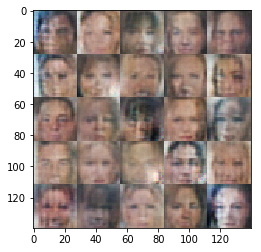

Epoch 0 The No. 2510 steps loss_d is 0.35968926548957825 The No. 2510 steps loss_g is 8.509056091308594
Epoch 0 The No. 2520 steps loss_d is 0.6276096105575562 The No. 2520 steps loss_g is 1.3518738746643066
Epoch 0 The No. 2530 steps loss_d is 0.35525014996528625 The No. 2530 steps loss_g is 6.009016036987305
Epoch 0 The No. 2540 steps loss_d is 0.35888993740081787 The No. 2540 steps loss_g is 6.391512870788574
Epoch 0 The No. 2550 steps loss_d is 0.366800457239151 The No. 2550 steps loss_g is 4.9542236328125
Epoch 0 The No. 2560 steps loss_d is 0.7636181116104126 The No. 2560 steps loss_g is 1.1256632804870605
Epoch 0 The No. 2570 steps loss_d is 0.3511675298213959 The No. 2570 steps loss_g is 7.350854396820068
Epoch 0 The No. 2580 steps loss_d is 0.49150827527046204 The No. 2580 steps loss_g is 2.4923601150512695
Epoch 0 The No. 2590 steps loss_d is 0.36582398414611816 The No. 2590 steps loss_g is 4.937319278717041
Epoch 0 The No. 2600 steps loss_d is 0.416309654712677 The No. 2600 

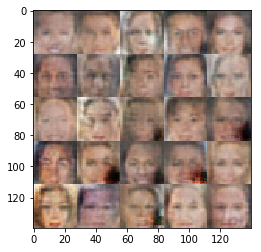

Epoch 0 The No. 2610 steps loss_d is 0.40949878096580505 The No. 2610 steps loss_g is 2.9293627738952637
Epoch 0 The No. 2620 steps loss_d is 0.38555988669395447 The No. 2620 steps loss_g is 4.174674034118652
Epoch 0 The No. 2630 steps loss_d is 0.38676291704177856 The No. 2630 steps loss_g is 9.240266799926758
Epoch 0 The No. 2640 steps loss_d is 0.36984747648239136 The No. 2640 steps loss_g is 8.946468353271484
Epoch 0 The No. 2650 steps loss_d is 0.6495635509490967 The No. 2650 steps loss_g is 1.6739492416381836
Epoch 0 The No. 2660 steps loss_d is 0.3754793107509613 The No. 2660 steps loss_g is 7.381414413452148
Epoch 0 The No. 2670 steps loss_d is 0.36777088046073914 The No. 2670 steps loss_g is 5.186086177825928
Epoch 0 The No. 2680 steps loss_d is 0.3528895080089569 The No. 2680 steps loss_g is 7.348146438598633
Epoch 0 The No. 2690 steps loss_d is 0.3732996881008148 The No. 2690 steps loss_g is 4.893502235412598
Epoch 0 The No. 2700 steps loss_d is 0.4456331133842468 The No. 27

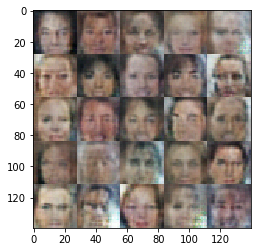

Epoch 0 The No. 2710 steps loss_d is 0.3495451509952545 The No. 2710 steps loss_g is 6.465543746948242
Epoch 0 The No. 2720 steps loss_d is 0.34994545578956604 The No. 2720 steps loss_g is 5.791980743408203
Epoch 0 The No. 2730 steps loss_d is 0.35009026527404785 The No. 2730 steps loss_g is 8.439165115356445
Epoch 0 The No. 2740 steps loss_d is 0.3582916557788849 The No. 2740 steps loss_g is 9.654258728027344
Epoch 0 The No. 2750 steps loss_d is 0.38184064626693726 The No. 2750 steps loss_g is 4.70149564743042
Epoch 0 The No. 2760 steps loss_d is 0.478628009557724 The No. 2760 steps loss_g is 2.7460970878601074
Epoch 0 The No. 2770 steps loss_d is 0.37026116251945496 The No. 2770 steps loss_g is 4.664371490478516
Epoch 0 The No. 2780 steps loss_d is 0.3824654519557953 The No. 2780 steps loss_g is 6.567148208618164
Epoch 0 The No. 2790 steps loss_d is 0.4195629358291626 The No. 2790 steps loss_g is 9.6882963180542
Epoch 0 The No. 2800 steps loss_d is 0.3610611855983734 The No. 2800 ste

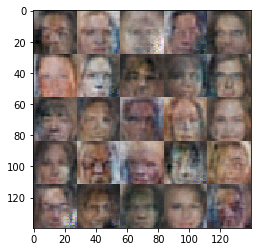

Epoch 0 The No. 2810 steps loss_d is 0.36361002922058105 The No. 2810 steps loss_g is 6.0628557205200195
Epoch 0 The No. 2820 steps loss_d is 0.34681347012519836 The No. 2820 steps loss_g is 7.782726287841797
Epoch 0 The No. 2830 steps loss_d is 0.4416041374206543 The No. 2830 steps loss_g is 4.0113444328308105
Epoch 0 The No. 2840 steps loss_d is 0.609795331954956 The No. 2840 steps loss_g is 1.7419660091400146
Epoch 0 The No. 2850 steps loss_d is 0.3832075893878937 The No. 2850 steps loss_g is 8.71706485748291
Epoch 0 The No. 2860 steps loss_d is 0.3492308259010315 The No. 2860 steps loss_g is 5.646530628204346
Epoch 0 The No. 2870 steps loss_d is 0.5358161330223083 The No. 2870 steps loss_g is 7.694637775421143
Epoch 0 The No. 2880 steps loss_d is 0.3521950840950012 The No. 2880 steps loss_g is 7.794109344482422
Epoch 0 The No. 2890 steps loss_d is 0.3836652338504791 The No. 2890 steps loss_g is 10.592994689941406
Epoch 0 The No. 2900 steps loss_d is 0.3486785888671875 The No. 2900 

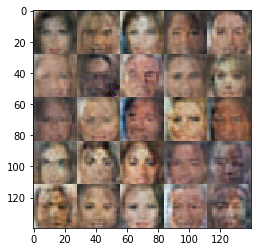

Epoch 0 The No. 2910 steps loss_d is 0.3533492386341095 The No. 2910 steps loss_g is 7.79692268371582
Epoch 0 The No. 2920 steps loss_d is 0.3531082570552826 The No. 2920 steps loss_g is 9.11950969696045
Epoch 0 The No. 2930 steps loss_d is 0.44098353385925293 The No. 2930 steps loss_g is 2.8146514892578125
Epoch 0 The No. 2940 steps loss_d is 0.4435333013534546 The No. 2940 steps loss_g is 7.4572978019714355
Epoch 0 The No. 2950 steps loss_d is 0.4558577835559845 The No. 2950 steps loss_g is 2.924306869506836
Epoch 0 The No. 2960 steps loss_d is 0.3451865315437317 The No. 2960 steps loss_g is 9.329793930053711
Epoch 0 The No. 2970 steps loss_d is 0.4065488278865814 The No. 2970 steps loss_g is 3.65427303314209
Epoch 0 The No. 2980 steps loss_d is 0.6111496686935425 The No. 2980 steps loss_g is 2.43251895904541
Epoch 0 The No. 2990 steps loss_d is 0.44596078991889954 The No. 2990 steps loss_g is 9.047733306884766
Epoch 0 The No. 3000 steps loss_d is 0.5247066020965576 The No. 3000 step

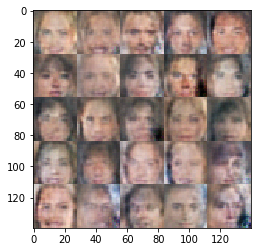

Epoch 0 The No. 3010 steps loss_d is 0.3546821177005768 The No. 3010 steps loss_g is 5.364041328430176
Epoch 0 The No. 3020 steps loss_d is 0.35674601793289185 The No. 3020 steps loss_g is 6.156911849975586
Epoch 0 The No. 3030 steps loss_d is 0.34791240096092224 The No. 3030 steps loss_g is 7.172909736633301
Epoch 0 The No. 3040 steps loss_d is 0.4142659902572632 The No. 3040 steps loss_g is 3.448230504989624
Epoch 0 The No. 3050 steps loss_d is 0.3726271092891693 The No. 3050 steps loss_g is 3.798394203186035
Epoch 0 The No. 3060 steps loss_d is 0.3501734137535095 The No. 3060 steps loss_g is 8.01409912109375
Epoch 0 The No. 3070 steps loss_d is 0.5470990538597107 The No. 3070 steps loss_g is 1.5843712091445923
Epoch 0 The No. 3080 steps loss_d is 0.34624016284942627 The No. 3080 steps loss_g is 7.837041854858398
Epoch 0 The No. 3090 steps loss_d is 0.34920039772987366 The No. 3090 steps loss_g is 6.948664665222168
Epoch 0 The No. 3100 steps loss_d is 0.348274290561676 The No. 3100 s

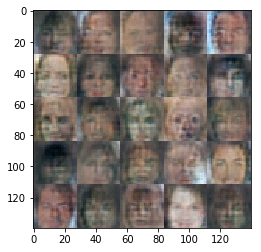

Epoch 0 The No. 3110 steps loss_d is 0.3526822030544281 The No. 3110 steps loss_g is 6.366708278656006
Epoch 0 The No. 3120 steps loss_d is 0.3581503629684448 The No. 3120 steps loss_g is 9.674600601196289
Epoch 0 The No. 3130 steps loss_d is 0.3452746272087097 The No. 3130 steps loss_g is 6.567790985107422
Epoch 0 The No. 3140 steps loss_d is 0.3530476987361908 The No. 3140 steps loss_g is 7.614016532897949
Epoch 0 The No. 3150 steps loss_d is 0.4030609726905823 The No. 3150 steps loss_g is 10.14813232421875
Epoch 0 The No. 3160 steps loss_d is 0.35715508460998535 The No. 3160 steps loss_g is 7.197544097900391


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.